# Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma, a type of cancer that can be deadly if not detected early, accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import pathlib
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

from sklearn.metrics import accuracy_score

In [9]:
data_directory = '/content/drive/My Drive/CNN_assignment'

# Defining the path for train and test images
data_dir_train = pathlib.Path(data_directory + '/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path(data_directory + '/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

# Printing the count of train and test dataset sizes
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:
1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion

In [10]:
batch_size = 32
img_height = 180
img_width = 180

# Training Dataset Creation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="training",  # Choose the correct parameter value to refer to the training data
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Validation Dataset Creation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split=0.2,
    subset="validation",  # Choose the correct parameter value to refer to the validation data
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List of the classes of skin cancer (the class_names attributes correspond to the directory names in alphabetical order)
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Dataset visualisation**

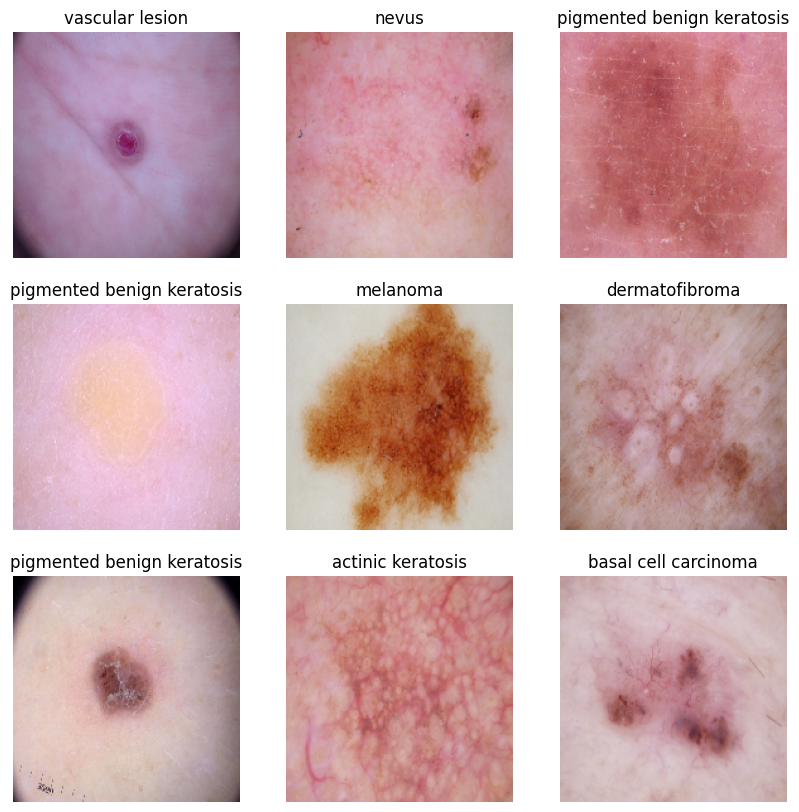

In [12]:
# A function to visualize one instance of each class
def visualize_one_instance_per_class(dataset, class_names):
    plt.figure(figsize=(10, 10))

    for images, labels in dataset.take(1):
        for i in range(9):  # Assuming there are 9 classes
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

# Function call for visualization
visualize_one_instance_per_class(train_ds, class_names)
plt.show()

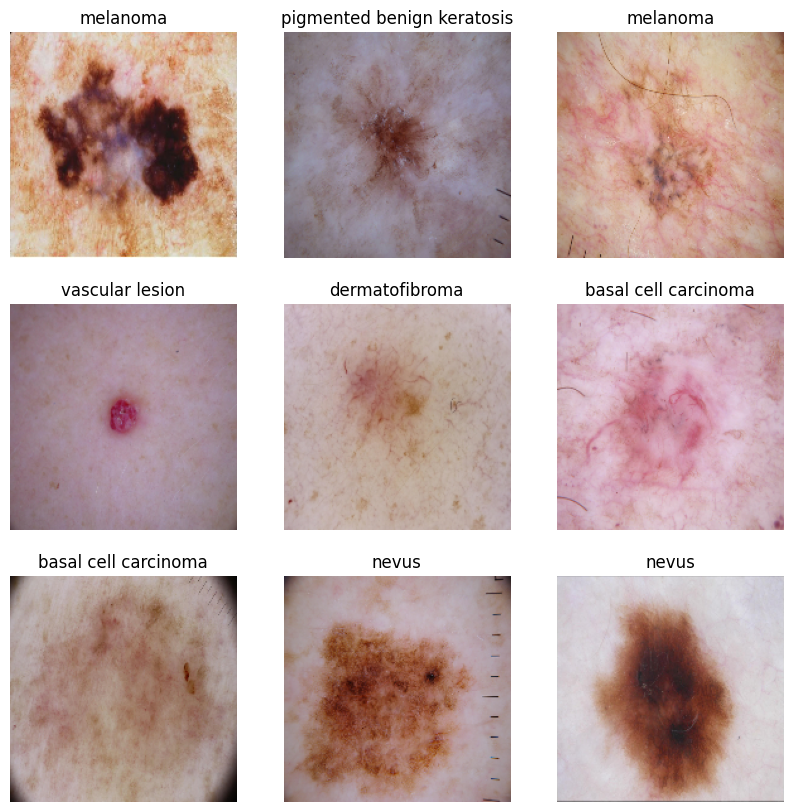

In [13]:
visualize_one_instance_per_class(val_ds, class_names)

In [14]:
# Creating a copy of train_ds before any modification
train_ds_copy1 = train_ds.map(lambda x, y: (x, y))

# Converting class labels to one-hot encoded format
num_classes = len(class_names)

# Ensuring that num_classes is set correctly
assert num_classes == 9, "Please set the correct number of classes."

train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

In [15]:
#The following lines for caching and prefetching data can significantly improve the performance of the training process.
#Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.
#Dataset.prefetch() overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

train_ds_copy1 = train_ds_copy1.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

**Model Building & training**

In [16]:
# Creating a CNN model
model = keras.Sequential([
    # Rescaling the input values to be in the [0, 1] range
    layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),

   # Adding convolutional layers and max-pooling layers
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Flattening the output before fully connected layers
    layers.Flatten(),

    # Adding fully connected layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes in the dataset
])

# Compilation of the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Printing a summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 256)      

The above summary conveys the layer information, output shape, number of parameters (weights and biases) associated with each layer, and the number of parameters that are trainable and updated during training.

Overall, the model has a total of 32,124,553 parameters, which will be optimized during training to make accurate predictions on the dataset.

In [17]:
# Model training
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 232s 817ms/step - loss: 2.1859 - accuracy: 0.1936 - val_loss: 1.9972 - val_accuracy: 0.3423
Epoch 2/20
56/56 [==============================] - 4s 77ms/step - loss: 1.9492 - accuracy: 0.2790 - val_loss: 1.9144 - val_accuracy: 0.2394
Epoch 3/20
56/56 [==============================] - 4s 75ms/step - loss: 1.8009 - accuracy: 0.3253 - val_loss: 1.7020 - val_accuracy: 0.4027
Epoch 4/20
56/56 [==============================] - 4s 75ms/step - loss: 1.6597 - accuracy: 0.3884 - val_loss: 1.5402 - val_accuracy: 0.4653
Epoch 5/20
56/56 [==============================] - 4s 76ms/step - loss: 1.5881 - accuracy: 0.4381 - val_loss: 1.5177 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 4s 75ms/step - loss: 1.5162 - accuracy: 0.4626 - val_loss: 1.4749 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 4s 75ms/step - loss: 1.4230 - accuracy: 0.5039 - val_loss: 1.3517 - val_accuracy: 0.5302
Epoch 8/20

**Observations**

Loss and Accuracy Trends:
1. Training and Validation Loss: The training loss (measured by "loss") and validation loss (measured by "val_loss") are decreasing over the epochs, which is a positive sign. This indicates that the model is learning from the data and becoming better at making predictions.
2. Training and Validation Accuracy: The training accuracy (measured by "accuracy") and validation accuracy (measured by "val_accuracy") are increasing over the epochs. This suggests that the model is improving in its ability to classify the data correctly.
3. The validation loss and accuracy show a fluctuating pattern. It is important to monitor these metrics to check for overfitting.

Overfitting:
1. There is a slight gap between the training and validation performance. This is more noticeable in the later epochs, where the training accuracy is higher than the validation accuracy. It's a sign that the model might be overfitting the training data.
2. To address overfitting, we could consider applying regularization techniques, adjusting model complexity, or increasing the size of the dataset. We could also consider data augmentation to increase the diversity of training data and potentially improve generalization.

**Visualization of the above model performance**


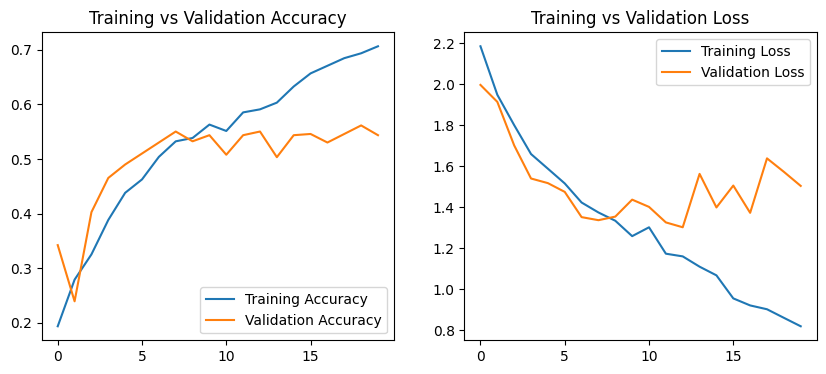

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()

**Application of Augmentation to address overfitting**

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rescale=1./255,  # Rescale pixel values to the [0, 1] range
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

#image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = class_names,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = class_names,
    batch_size = 64
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


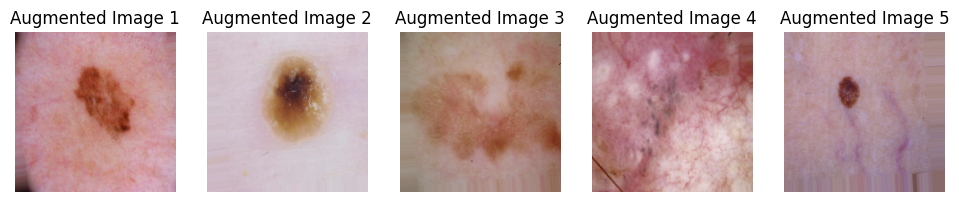

In [20]:
# Generating a batch of augmented images
augmented_images, _ = next(train_batches)  # Change 'train_data_gen' to your data generator

# Number of images to display
num_images_to_display = 5

# Plotting the augmented images
plt.figure(figsize=(12, 6))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(augmented_images[i])
    plt.title(f"Augmented Image {i + 1}")
    plt.axis('off')

plt.show()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 256)      

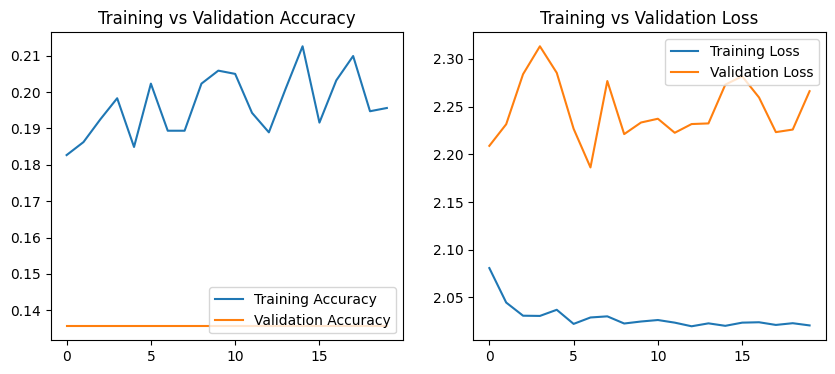

In [21]:
model_aug = keras.Sequential([
    # Rescaling the input values to be in the [0, 1] range
    layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=(180, 180, 3)),

    # Adding convolutional layers and max-pooling layers
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Flattening the output before fully connected layers
    layers.Flatten(),

    # Adding fully connected layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes in the dataset
])

# Compilation of the model
model_aug.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Printing a summary of the model
model_aug.summary()


# Model training
epochs = 20
history = model_aug.fit(
  train_batches,
  validation_data=valid_batches,
  epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()

The dramatic change in model performance after augmentation could be attributed to several factors:
1. Data Augmentation Quality: The choice of data augmentation techniques and their parameters can greatly impact the quality of augmented data. In the post-augmentation scenario, it appears that augmentation may have introduced too much variability or distortion, leading to lower model performance. This requires further fine-tuning of the augmentation parameters to produce more realistic and helpful augmented images.
2. Overfitting: The model's performance after augmentation is worse because of overfitting. While augmentation helps to reduce overfitting by providing more diverse training examples, the increased variability in augmented data might have made it harder for the model to generalize. To address this, regularization techniques such as dropout and L2 regularization could be leveraged to combat overfitting. Further tuning of the hyperparameters could also be considered.
3. Class Imbalance: Data augmentation should ideally maintain class balance. Perhaps the original dataset was imbalanced and augmentation didn't address this properly, thereby affecting the model's performance. The augmentation process must maintain class distribution.



In [22]:
#checking the shape of non-augmented data
iterator = iter(train_ds)

# Obtaining a batch of data from the dataset
sample_batch = next(iterator)

# Checking the shape of the train data
data, labels = sample_batch
print("Shape of data:", data.shape)
print("Shape of labels:", labels.shape)


# Checking the shape of augmented data
iterator = iter(train_batches)

# Obtaining a batch of data from the dataset
sample_batch = next(iterator)

# Checking the shape of the data
data, labels = sample_batch
print("Shape of augmented data:", data.shape)
print("Shape of augmented labels:", labels.shape)


Shape of data: (32, 180, 180, 3)
Shape of labels: (32, 9)
Shape of augmented data: (64, 180, 180, 3)
Shape of augmented labels: (64, 9)


**Examination of current class distribution in the training dataset**

Class with the least number of samples: seborrheic keratosis
Proportionate number of samples per class:
vascular lesion: 6.21%
squamous cell carcinoma: 8.08%
melanoma: 19.56%
pigmented benign keratosis: 20.63%
nevus: 15.94%
dermatofibroma: 4.24%
seborrheic keratosis: 3.44%
actinic keratosis: 5.09%
basal cell carcinoma: 16.79%


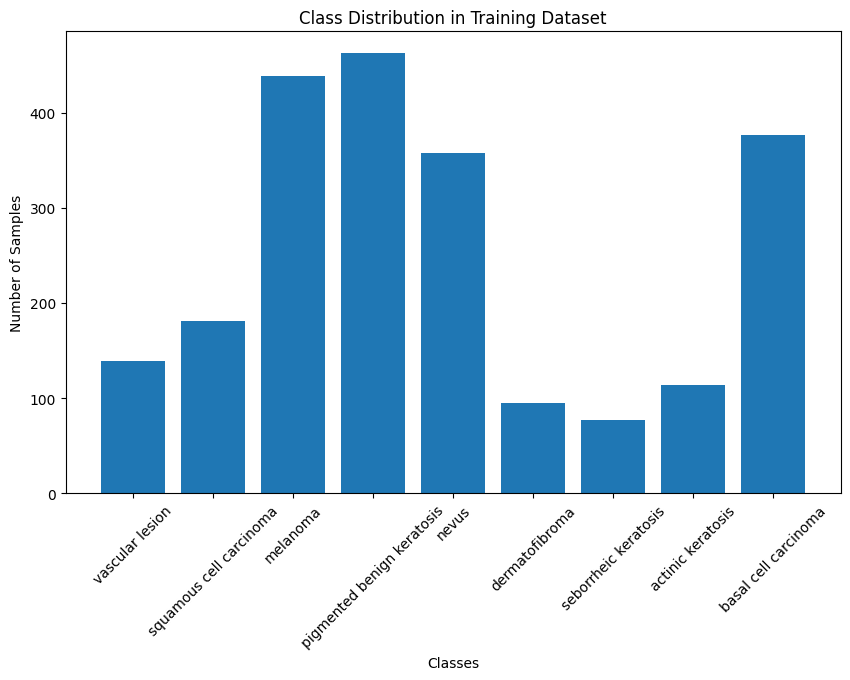

In [23]:
# List the subdirectories in the data directory, each representing a class
class_names = os.listdir(data_dir_train)

# Initialize an empty dictionary to store the count of samples per class
class_sample_counts = {}

# Loop through each class directory and count the number of samples
for class_name in class_names:
    class_path = os.path.join(data_dir_train, class_name)
    num_samples = len(os.listdir(class_path))
    class_sample_counts[class_name] = num_samples

# Find the class with the least number of samples
min_class = min(class_sample_counts, key=class_sample_counts.get)

# Find the classes that dominate the data in terms of the proportionate number of samples
total_samples = sum(class_sample_counts.values())
proportionate_classes = {
    class_name: count / total_samples for class_name, count in class_sample_counts.items()
}

# Print the results
print(f"Class with the least number of samples: {min_class}")
print("Proportionate number of samples per class:")
for class_name, proportion in proportionate_classes.items():
    print(f"{class_name}: {proportion:.2%}")

# Plot a bar chart to visualize class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_sample_counts.keys(), class_sample_counts.values())
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Dataset')
plt.xticks(rotation=45)
plt.show()


1. Seborrheic Keratosis is the class with the least number of samples.
2. The classes which dominate the data in terms of the proportionate number of samples:
   * melanoma: 19.56%
   * pigmented benign keratosis: 20.63%
   * nevus: 15.94%
   * basal cell carcinoma: 16.79%

**Class imbalance rectification**

In [24]:
!pip install Augmentor
import Augmentor

# Listing the subdirectories in the data directory, each representing a class
class_names = os.listdir(data_dir_train)
ing Augmentor pipeline for each class
for class_name in class_names:
    class_path = os.path.join(data_dir_train, class_name)

    # Defining an Augmentor pipeline for the current class
    pipeline = Augmentor.Pipeline(class_path)

    # Specifying augmentation operations you want to apply (you can customize this)
    pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    pipeline.flip_left_right(probability=0.5)
    pipeline.zoom_random(probability=0.5, percentage_area=0.8)

    target_num_samples = 500
    # Specifying the number of additional samples we want to generate
    # This can be adjusted based on the desired balance in each class
    num_additional_samples = target_num_samples - len(os.listdir(class_path))

    # Generating augmented samples
    pipeline.sample(num_additional_samples)


Initialised with 139 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A875E16E140>: 100%|██████████| 360/360 [00:15<00:00, 23.39 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A8762D6BA00>: 100%|██████████| 318/318 [00:12<00:00, 24.65 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A8762E0FD30>: 100%|██████████| 61/61 [00:13<00:00,  4.68 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A8762D6BBB0>: 100%|██████████| 37/37 [00:01<00:00, 30.35 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7A8762E0ECE0>: 100%|██████████| 142/142 [00:28<00:00,  4.96 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A8762E0FA60>: 100%|██████████| 404/404 [00:16<00:00, 25.13 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A8762EF2AA0>: 100%|██████████| 422/422 [00:39<00:00, 10.81 Samples/s]


Initialised with 114 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A8762D6B790>: 100%|██████████| 385/385 [00:15<00:00, 24.83 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/My Drive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A8762EF2AA0>: 100%|██████████| 123/123 [00:04<00:00, 27.04 Samples/s]


**Model Building & training on the rectified class imbalance data**

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Defining data directories
train_data_dir = pathlib.Path(data_directory + '/Skin cancer ISIC The International Skin Imaging Collaboration/Rectified_Trainset')

# Setting hyperparameters
batch_size = 64
epochs = 30

# Image data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split = 0.2
)

# Creating data generators with a validation split

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(180, 180),
    batch_size=batch_size,
    class_mode='categorical',  # 9 classes
    subset='training',  # Training split
)
validation_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(180, 180),
    batch_size=batch_size,
    class_mode='categorical',  # 9 classes
    subset='validation',  # Validation split
)

# Defining the CNN model
model_rectified = keras.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 classes
])

# Learning rate schedule and optimizer
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.7
)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# Compilation of the model
model_rectified.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model_rectified.summary()


Found 1805 images belonging to 9 classes.
Found 447 images belonging to 9 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 178, 178, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 89, 89, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 43, 43, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 256)       295168    
                                     

Epoch 1/30
29/29 [==============================] - 38s 1s/step - loss: 2.1296 - accuracy: 0.1784 - val_loss: 1.9492 - val_accuracy: 0.2148
Epoch 2/30
29/29 [==============================] - 36s 1s/step - loss: 1.8011 - accuracy: 0.3368 - val_loss: 1.4464 - val_accuracy: 0.4407
Epoch 3/30
29/29 [==============================] - 29s 1s/step - loss: 1.5784 - accuracy: 0.4244 - val_loss: 1.4548 - val_accuracy: 0.4430
Epoch 4/30
29/29 [==============================] - 29s 1s/step - loss: 1.3735 - accuracy: 0.4803 - val_loss: 1.2818 - val_accuracy: 0.5056
Epoch 5/30
29/29 [==============================] - 29s 998ms/step - loss: 1.3210 - accuracy: 0.5125 - val_loss: 1.2929 - val_accuracy: 0.5078
Epoch 6/30
29/29 [==============================] - 30s 1s/step - loss: 1.2910 - accuracy: 0.5141 - val_loss: 1.2621 - val_accuracy: 0.5034
Epoch 7/30
29/29 [==============================] - 29s 1s/step - loss: 1.2721 - accuracy: 0.5324 - val_loss: 1.3831 - val_accuracy: 0.5034
Epoch 8/30
29/29 

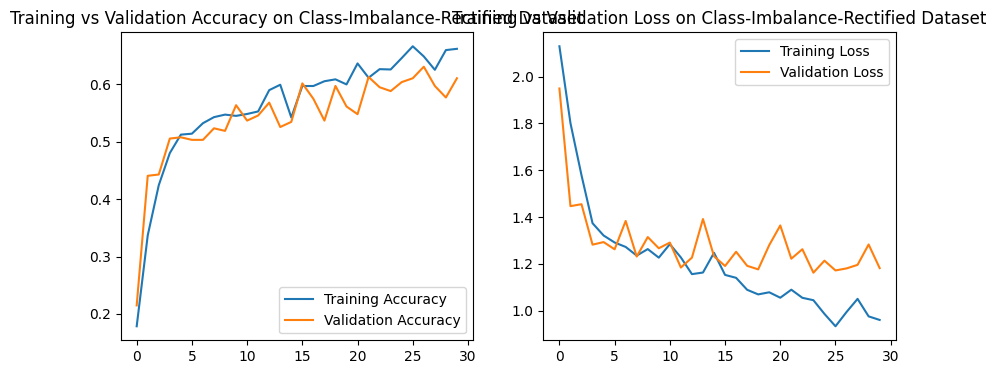

In [26]:
# Training the model
history = model_rectified.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy on Class-Imbalance-Rectified Dataset')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss on Class-Imbalance-Rectified Dataset')
plt.show()

An analysis of the output and the model's performance is provided below:

1. **Loss and Accuracy Trends**:
   - The output shows the training and validation loss and accuracy for each epoch. Loss is a measure of how well the model is performing, with lower values indicating better performance. Accuracy indicates the proportion of correctly classified samples.
   - At the beginning of training (Epoch 1), both training and validation accuracy are relatively low. The model's accuracy is approximately 17.84% on the training data and 21.48% on the validation data.
   - As training progresses, both training and validation accuracy improve. By Epoch 4, training accuracy reaches around 48.03%, and validation accuracy is approximately 50.56%.
   - The model continues to improve, reaching an accuracy of around 66.20% on the training data and 61.07% on the validation data by the end of training (Epoch 30).

2. **Loss Trends**:
   - Training loss is relatively high at the beginning but gradually decreases, indicating that the model is learning from the data. By the end of training, the training loss is 0.9601.
   - Validation loss shows a similar trend, decreasing over time. By the end of training, the validation loss is 1.1817.

3. **Overfitting**:
   - Initially, the model's training accuracy is lower than the validation accuracy, suggesting underfitting. As training progresses, the training accuracy surpasses the validation accuracy, indicating overfitting.

4. **Training Time**:
   - The training time per epoch is also provided. In this case, each epoch takes around 29 to 38 seconds.

5. **Model Performance**:
   - The final validation accuracy of around 61.07% suggests that the model can correctly classify approximately 61% of the validation samples. The model has learned to some extent from the training data but may still benefit from further optimization or the application of advanced architectures or techniques.

To improve model performance, we could consider the following steps:
   - Experiment with different model architectures or hyperparameters.
   - Implement regularization techniques such as L2 regularization to mitigate overfitting.
   - Further adjust the learning rate and learning rate schedule.
   - Increase the training dataset size to expose the model to more variations in the data.

It's important to monitor training and validation metrics closely and use these insights to fine-tune your model and achieve better results.

In [27]:
# Saving the final model on rectified dataset
model_rectified.save('skin_cancer_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
